# fct_monthly_schedule_rt_route_direction_summary
* schedule stats (headway, freq, n_trips) by route-direction
* operator summary charts
* [Tiffany's explanation](https://github.com/cal-itp/data-analyses/issues/1752#issuecomment-3563818122)

In [1]:
import datetime
import sys

import _sql_query
import google.auth
import pandas as pd
from google.cloud import bigquery
from loguru import logger
from shared_utils import rt_dates
from update_vars import SEGMENT_GCS

credentials, project = google.auth.default()

import _operator_grain_route_dir_visuals as _report_operator_visuals
import _portfolio_charts
import altair as alt
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import catalog_utils, gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

readable_dict = OmegaConf.load("new_readable.yml")

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GTFS_DATA_DICT = catalog_utils.get_catalog("gtfs_analytics_data")

In [4]:
# rt_dates.DATES

In [5]:
analysis_name = "City and County of San Francisco"

In [6]:
def formatted(number):
    return "{:,}".format(number)

In [7]:
url = "gs://calitp-analytics-data/data-analyses/gtfs_digest/processed/schedule_rt_route_direction_summary_2025_12.parquet"

In [8]:
df = pd.read_parquet(url)

In [9]:
df.head(2).drop(columns = ['Frequency All Day', "Frequency Offpeak", "Frequency Peak"])

,Date,Name,Route,Direction,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway All Day,Headway Peak,Headway Offpeak
0,October 2025,Sacramento Schedule,020__20 FSL Route 20,1,1.20,NaN,NaN,2.00,Weekday,Sacramento Regional Transit District,recbzZQUIdMmFvm1r,72.00,36.00,300.00,NaN,NaN
2,October 2025,Monterey Salinas Schedule,040__40 Salinas - Rancho Cielo,0,0.28,NaN,NaN,1.00,Weekday,Monterey-Salinas Transit,recysP9m9kjCJwHZe,17.00,17.00,300.00,NaN,NaN


In [10]:
subset_df = df.loc[df["Analysis Name"].isin([analysis_name])]

In [11]:
subset_df.shape

(371, 19)

In [12]:
subset_df.head(2)

,Date,Name,Route,Direction,Frequency All Day,Frequency Offpeak,Frequency Peak,Daily Service Hours,Daily Trips Peak,Daily Trips Offpeak,Daily Trips All Day,Day Type,Analysis Name,Source Record Id,Daily Service Minutes,Average Scheduled Minutes,Headway All Day,Headway Peak,Headway Offpeak
910,October 2025,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Saturday,City and County of San Francisco,recHD22phgJs34JHP,32.00,32.00,240.00,NaN,NaN
911,October 2025,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,Sunday,City and County of San Francisco,recHD22phgJs34JHP,32.00,32.00,240.00,NaN,NaN


In [13]:
len(subset_df.drop_duplicates())

371

### Operator Grain: Scheduled Minutes

In [14]:
def create_route_dropdown(df: pd.DataFrame):
    routes_list = df["Route"].unique().tolist()
    route_dropdown = alt.binding_select(
        options=routes_list,
        name="Routes: ",
    )

    # Column that controls the bar charts
    xcol_param = alt.selection_point(
        fields=["Route"], value=routes_list[0], bind=route_dropdown
    )
    return xcol_param

In [15]:
def create_scheduled_minutes(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.avg_scheduled_minutes

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [16]:
create_scheduled_minutes(subset_df)

alt.HConcatChart(...)

### Operator: Total Scheduled Trips for Vehicles Going Direction X
* Use `daily_trips_all_day`

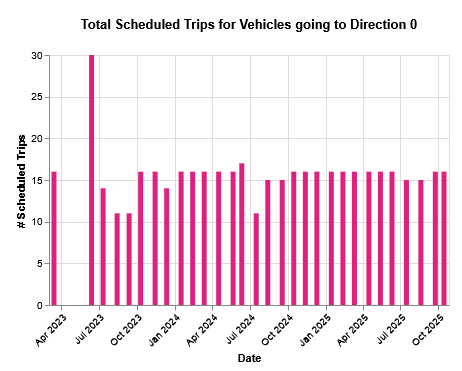

In [17]:
def create_scheduled_trips(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.scheduled

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Daily Trips All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Daily Trips All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [18]:
create_scheduled_trips(subset_df)

alt.HConcatChart(...)

### Frequency of Trips Peak/Off Peak for Direction X
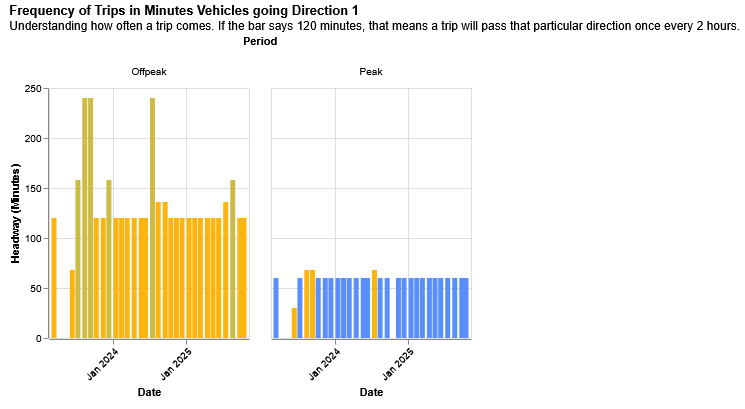

In [19]:
def create_frequency(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.frequency

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Headway All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Headway All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [20]:
create_frequency(subset_df)

alt.HConcatChart(...)

#### Statewide Metric

### Text Table

In [21]:
def create_text_table(df: pd.DataFrame) -> pd.DataFrame:
    most_recent_date = df["Date"].max()
    most_recent_df = df.loc[
        (df.Date == most_recent_date) & (df["Day Type"] == "Weekday")
    ]
    text_table_df = most_recent_df.melt(
        id_vars=[
            "Date",
            "Route",
            "Direction",
        ],
        value_vars=[
            "Average Scheduled Minutes",
            "Average Scheduled Minutes",
            "Daily Trips All Day",
            "Headway All Day",
            "Headway Peak",
            "Headway Offpeak",
        ],
    ).sort_values(by=["Route", "Direction"])

    text_table_df.value = text_table_df.value.fillna(0)
    text_table_df.value = text_table_df.value.astype(int)
    text_table_df.value = text_table_df.value.astype(str)
    text_table_df.value = text_table_df.value.replace("0", "N/A")

    text_table_df["Zero"] = 0

    text_table_df["combo_col"] = (
        text_table_df.variable.astype(str) + ": " + text_table_df.value.astype(str)
    )
    text_table_df["Direction"] = text_table_df.Direction.astype(str)

    return text_table_df

In [22]:
def text_table(df: pd.DataFrame) -> alt.Chart:

    # Create the chart
    text_chart = (
        alt.Chart(df)
        .mark_text()
        .encode(x=alt.X("Zero:Q", axis=None), y=alt.Y("combo_col", axis=None))
    )

    text_chart = text_chart.encode(text="combo_col:N")

    return text_chart

In [23]:
df2 = create_text_table(subset_df)

In [24]:
def create_text_graph(df: pd.DataFrame):
    chart_dict = readable_dict.avg_scheduled_minutes
    
    df2 = create_text_table(df)

    # Create dropdown menus
    options = ["0", "1"]
    input_dropdown = alt.binding_radio(
        # Add the empty selection which shows all when clicked
        options=options,
        labels=options,
        name="Direction: ",
    )
    selection = alt.selection_point(
        fields=["Direction"],
        value=options[0],
        bind=input_dropdown,
    )

    xcol_param = create_route_dropdown(df)

    chart = (
        (
            _report_operator_visuals.configure_chart(
                text_table(df2),
                width=400,
                height=250,
                title=chart_dict.title,
                subtitle=chart_dict.subtitle,
            )
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
        .add_params(selection)
        .transform_filter(selection)
    )

    return chart

In [25]:
create_text_table(subset_df)

,Date,Route,Direction,variable,value,Zero,combo_col
87,October 2025,12__12 FOLSOM-PACIFIC,0,Average Scheduled Minutes,39,0,Average Scheduled Minutes: 39
224,October 2025,12__12 FOLSOM-PACIFIC,0,Daily Trips All Day,84,0,Daily Trips All Day: 84
361,October 2025,12__12 FOLSOM-PACIFIC,0,Headway All Day,14,0,Headway All Day: 14
498,October 2025,12__12 FOLSOM-PACIFIC,0,Headway Peak,10,0,Headway Peak: 10
635,October 2025,12__12 FOLSOM-PACIFIC,0,Headway Offpeak,N/A,0,Headway Offpeak: N/A
88,October 2025,12__12 FOLSOM-PACIFIC,1,Average Scheduled Minutes,39,0,Average Scheduled Minutes: 39
225,October 2025,12__12 FOLSOM-PACIFIC,1,Daily Trips All Day,84,0,Daily Trips All Day: 84
362,October 2025,12__12 FOLSOM-PACIFIC,1,Headway All Day,14,0,Headway All Day: 14
499,October 2025,12__12 FOLSOM-PACIFIC,1,Headway Peak,10,0,Headway Peak: 10
636,October 2025,12__12 FOLSOM-PACIFIC,1,Headway Offpeak,N/A,0,Headway Offpeak: N/A
